In [1]:
### Keep a record - the time taken to run this script
import time
start_time = time.time()

In [2]:
from Model import RedemptionModel 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

c:\Users\elias\Anaconda3\envs\mb-ds-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the data

In [3]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file)
    return df

#####  Source: https://open.toronto.ca/dataset/toronto-island-ferry-ticket-counts/ 


In [4]:
## Load the data

df = load_data('./data/Toronto Island Ferry Ticket Counts.csv')

#### Initial inspection
- See the first few rows of the dataframe
- Check datatypes. 
- Timestamp in object (string) format
- Convert Timestamp from string to DateTime
- Set the Timestamp as index of the dataframe 

In [5]:
print("First few rows of the data:")
print("="*50)
print(df.head(3))
print("="*50)
print("Check data types")
print("="*50)
print(df.info())

## We see that Timestamp is in string format, we need to convert it to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%dT%H:%M:%S')

## check the data types after conversion
print("="*50)
print("Data types after conversion:")
print("="*50)
print(df.info())
print("="*50)


First few rows of the data:
   _id            Timestamp  Redemption Count  Sales Count
0    1  2025-06-06T18:45:00                83            0
1    2  2025-06-06T18:30:00                82            0
2    3  2025-06-06T18:15:00                88          103
Check data types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246425 entries, 0 to 246424
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   _id               246425 non-null  int64 
 1   Timestamp         246425 non-null  object
 2   Redemption Count  246425 non-null  int64 
 3   Sales Count       246425 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246425 entries, 0 to 246424
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   _id               

In [6]:
# drop the _id column
df.drop(columns=['_id'], inplace=True)
# set the Timestamp as index
df.set_index('Timestamp', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246425 entries, 2025-06-06 18:45:00 to 2015-05-01 13:30:00
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Redemption Count  246425 non-null  int64
 1   Sales Count       246425 non-null  int64
dtypes: int64(2)
memory usage: 5.6 MB


In [7]:
# Resample to daily frequency
df_daily = df.resample('D').sum()
# df_daily[['Sales Count', 'Redemption Count']].corr()

In [8]:
df_daily_2022 = df_daily[df_daily.index >= '2022-01-01']
df_daily_2022 = df_daily_2022[df_daily_2022.index <= '2024-12-31']

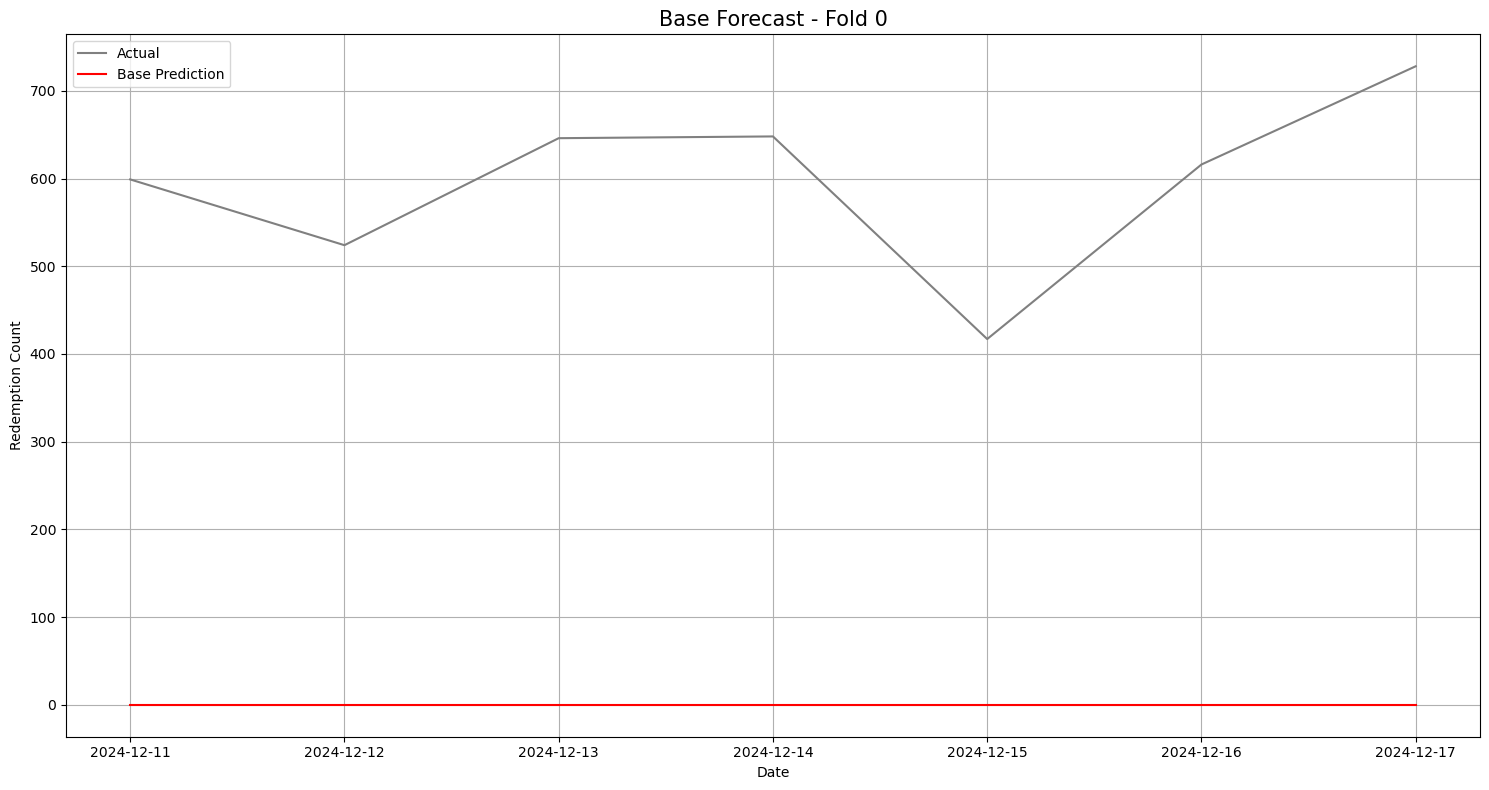

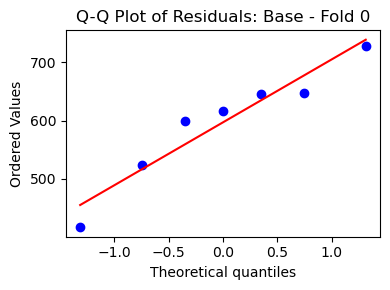

14:49:27 - cmdstanpy - INFO - Chain [1] start processing
14:49:28 - cmdstanpy - INFO - Chain [1] done processing


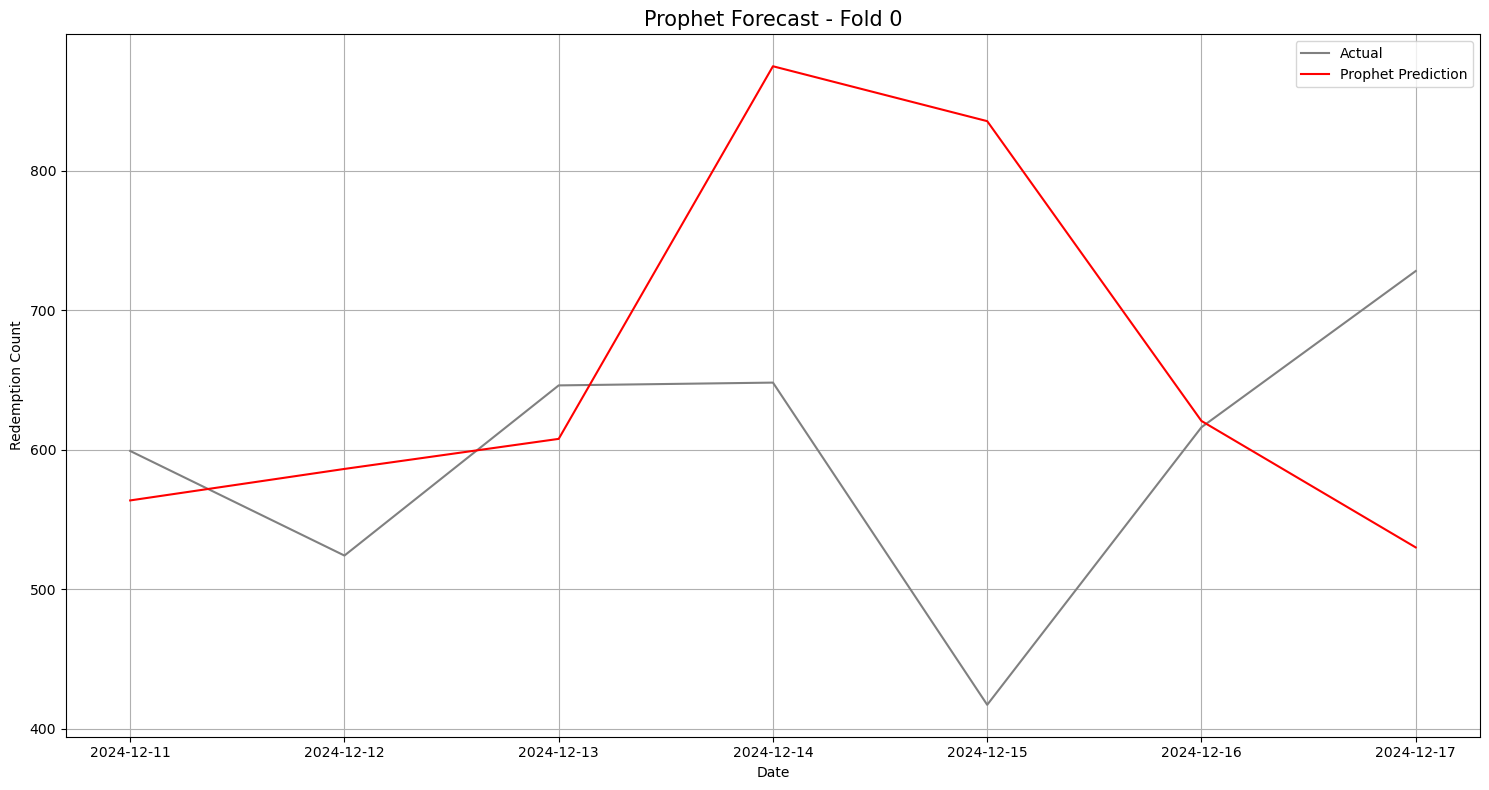

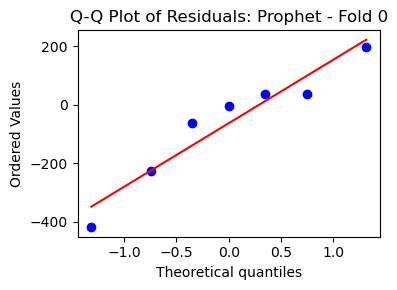

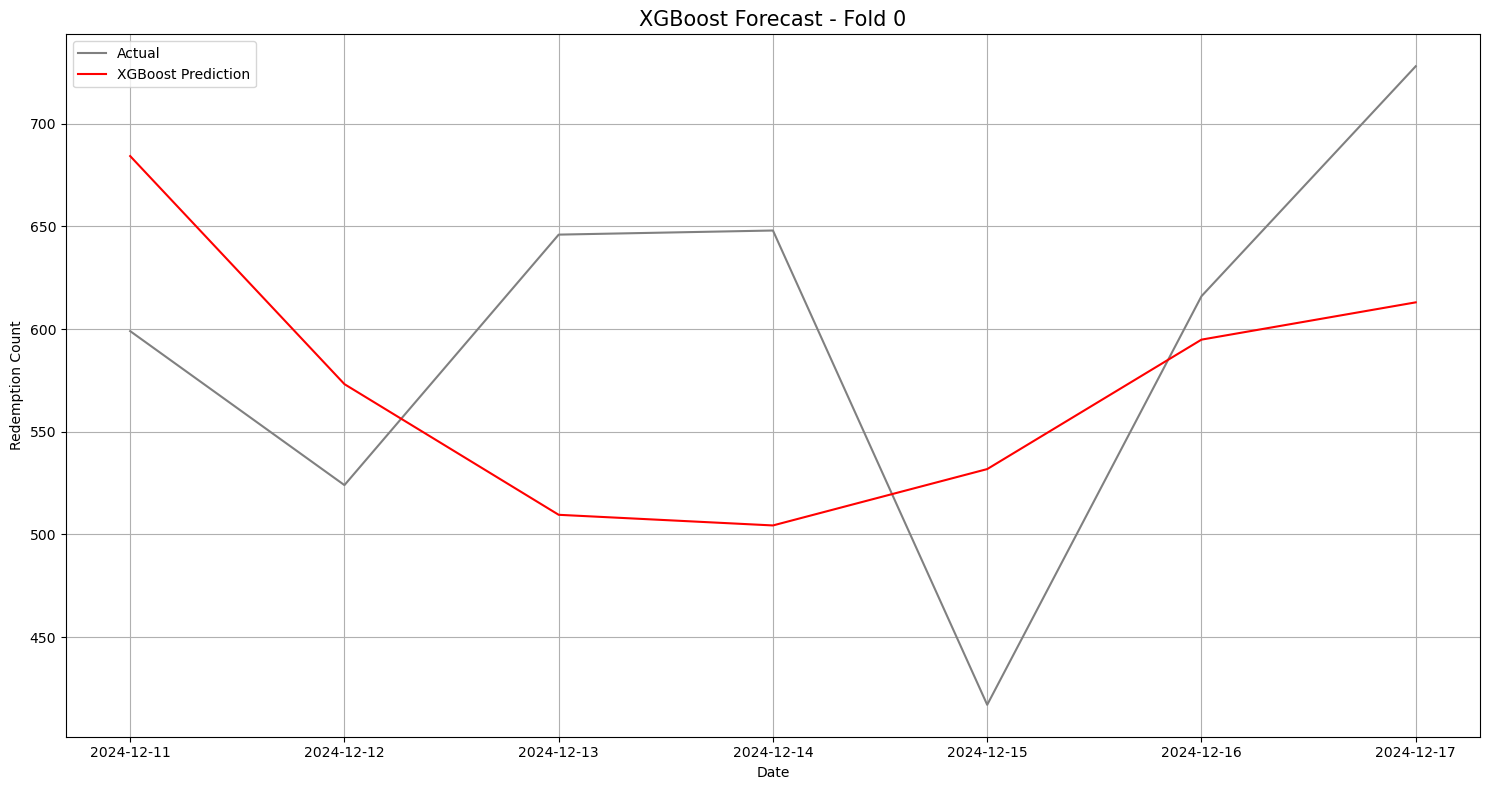

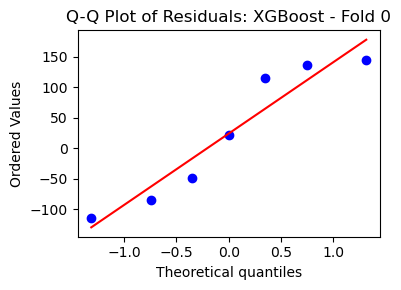

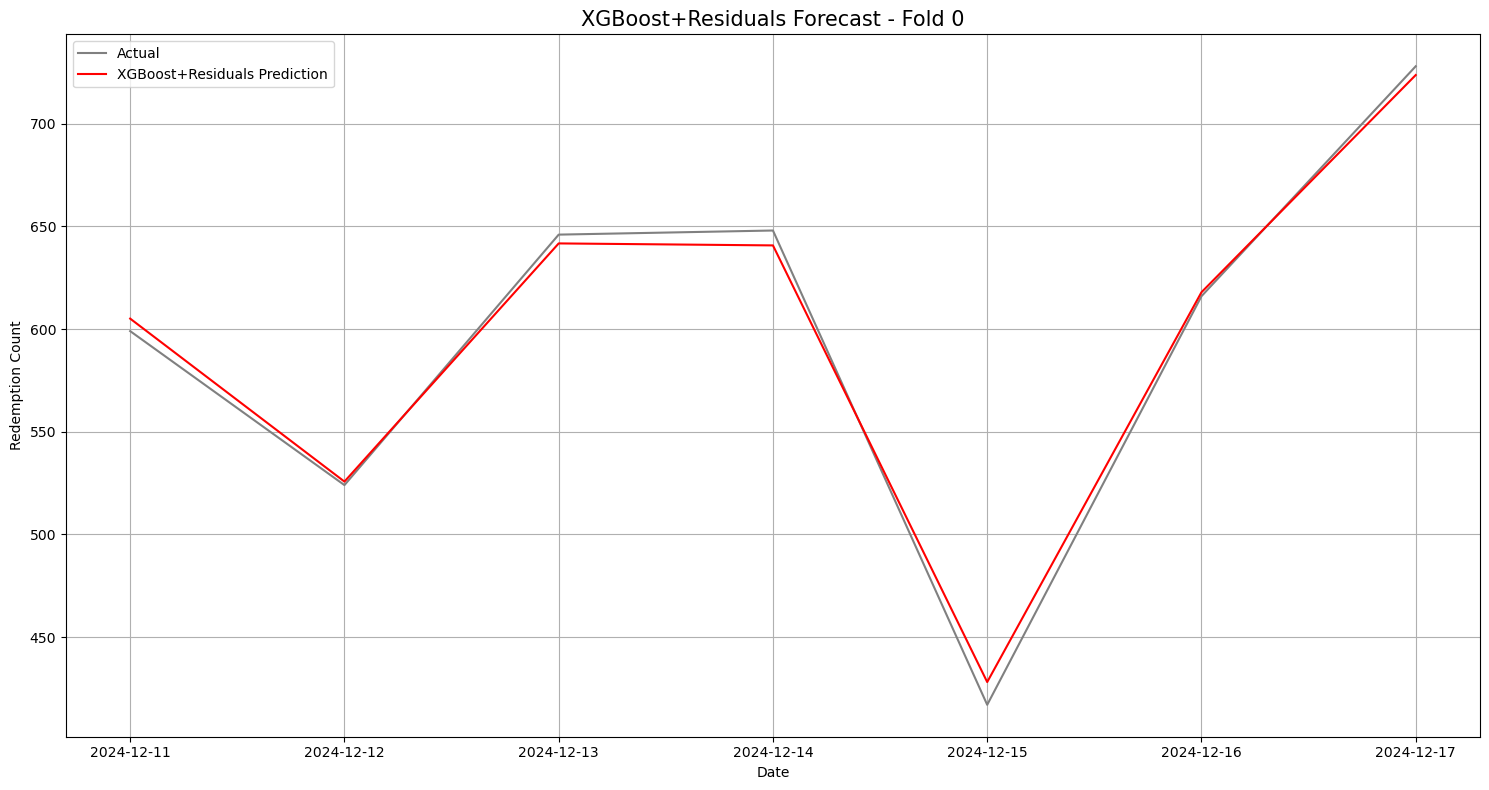

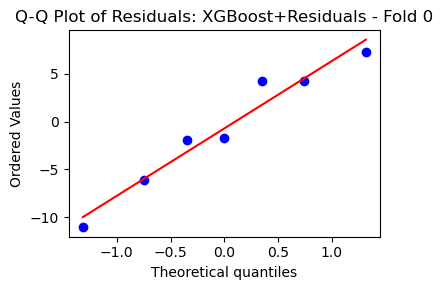

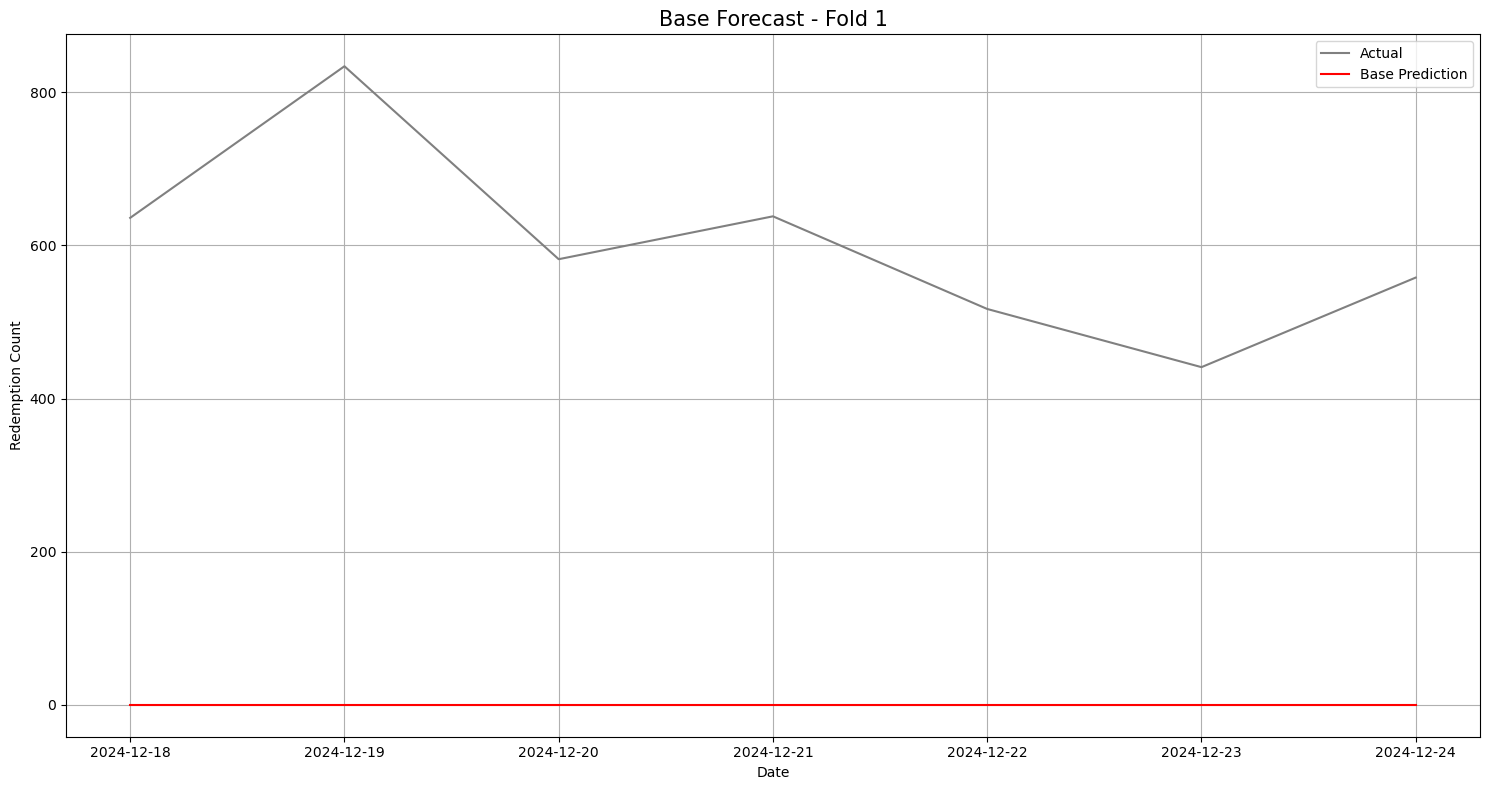

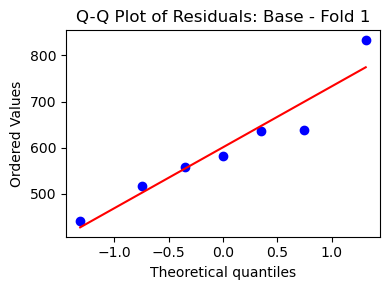

14:49:30 - cmdstanpy - INFO - Chain [1] start processing
14:49:30 - cmdstanpy - INFO - Chain [1] done processing


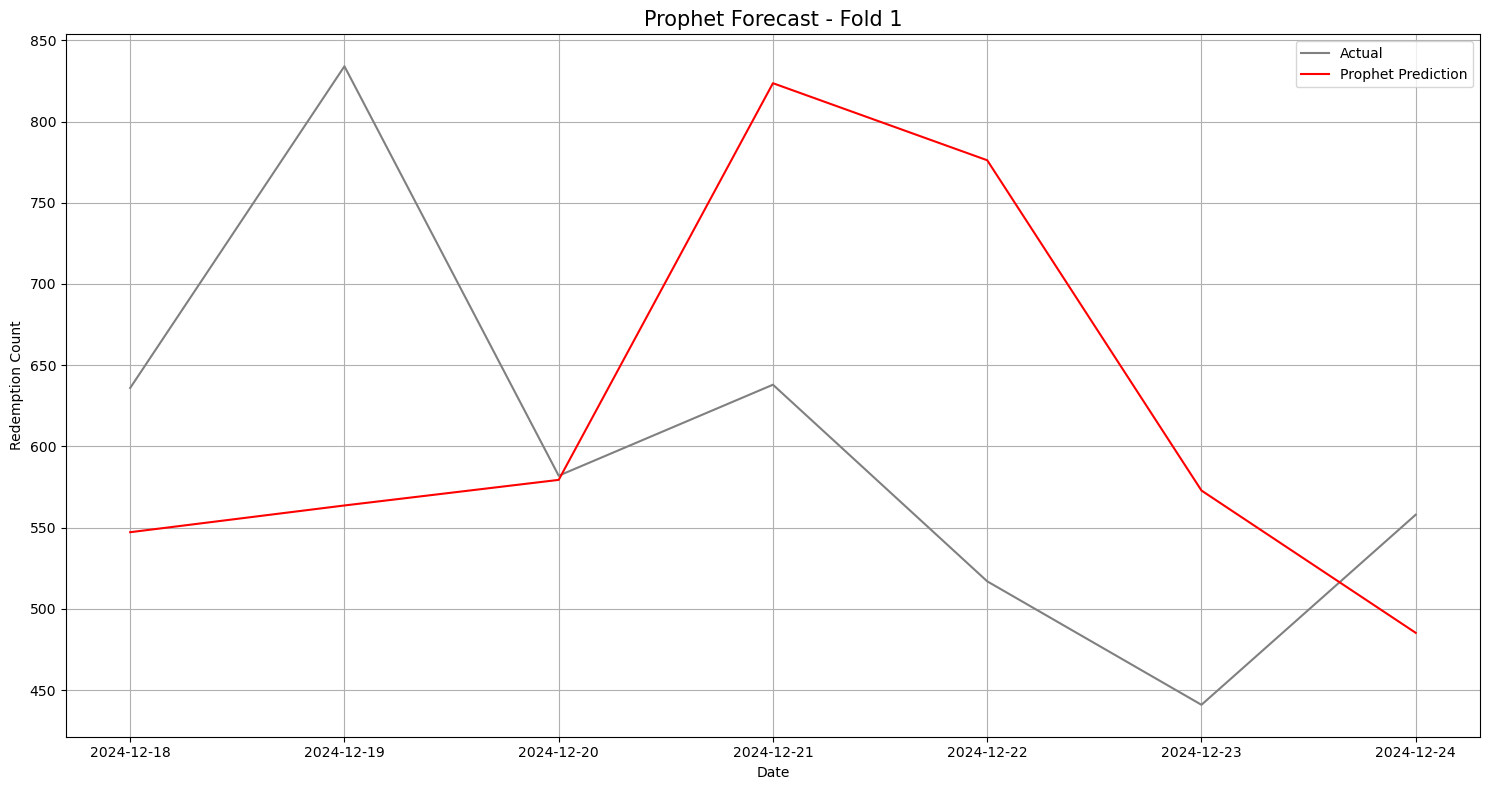

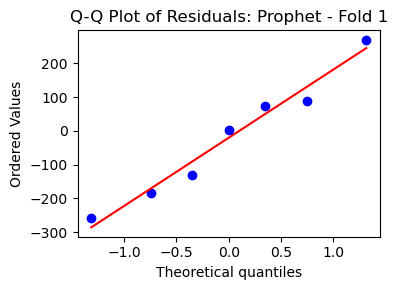

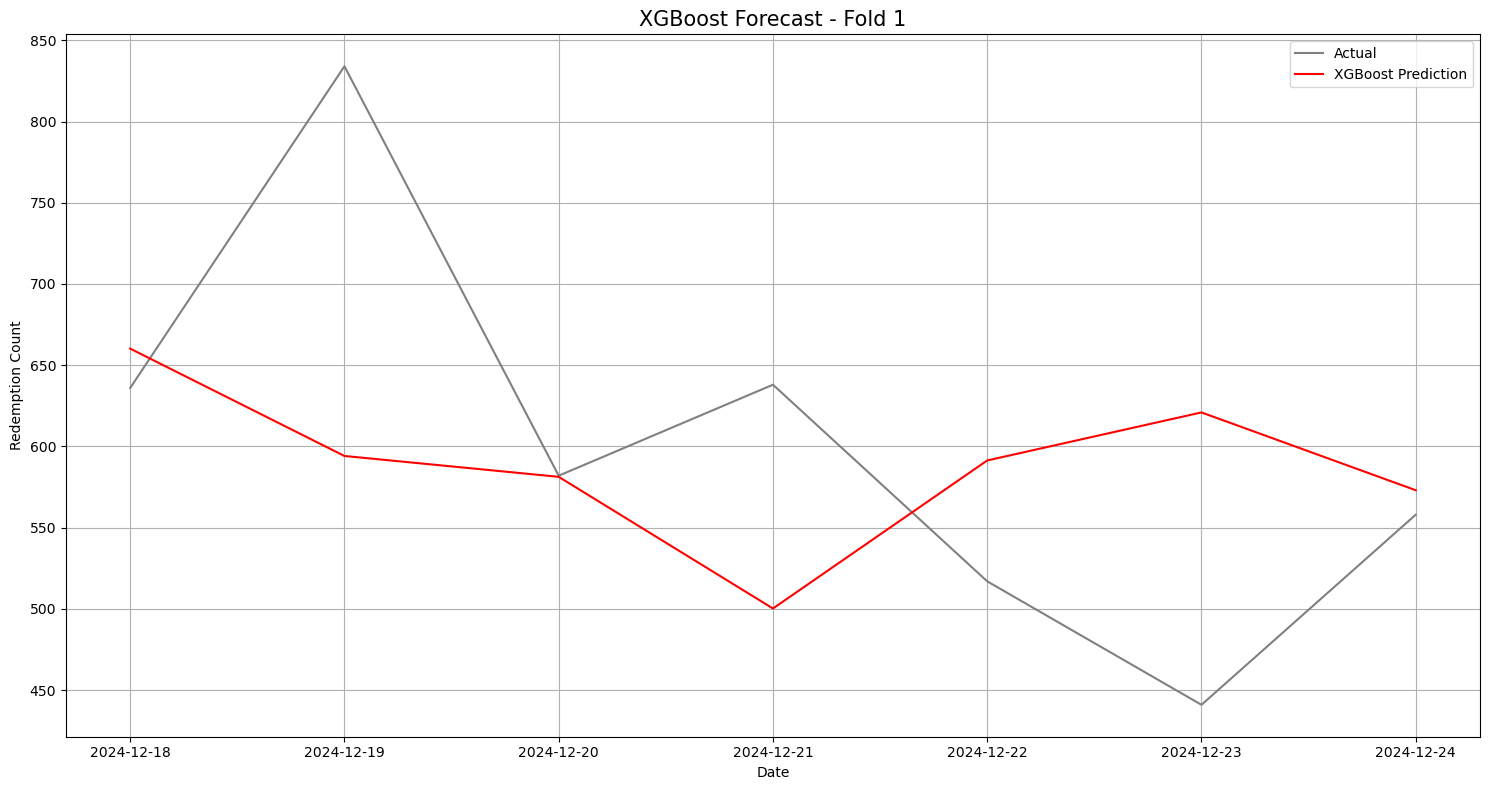

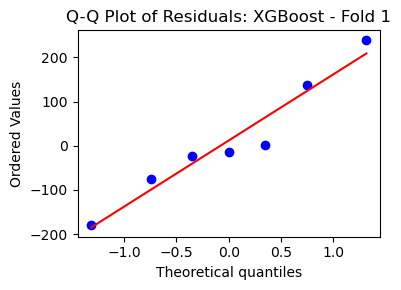

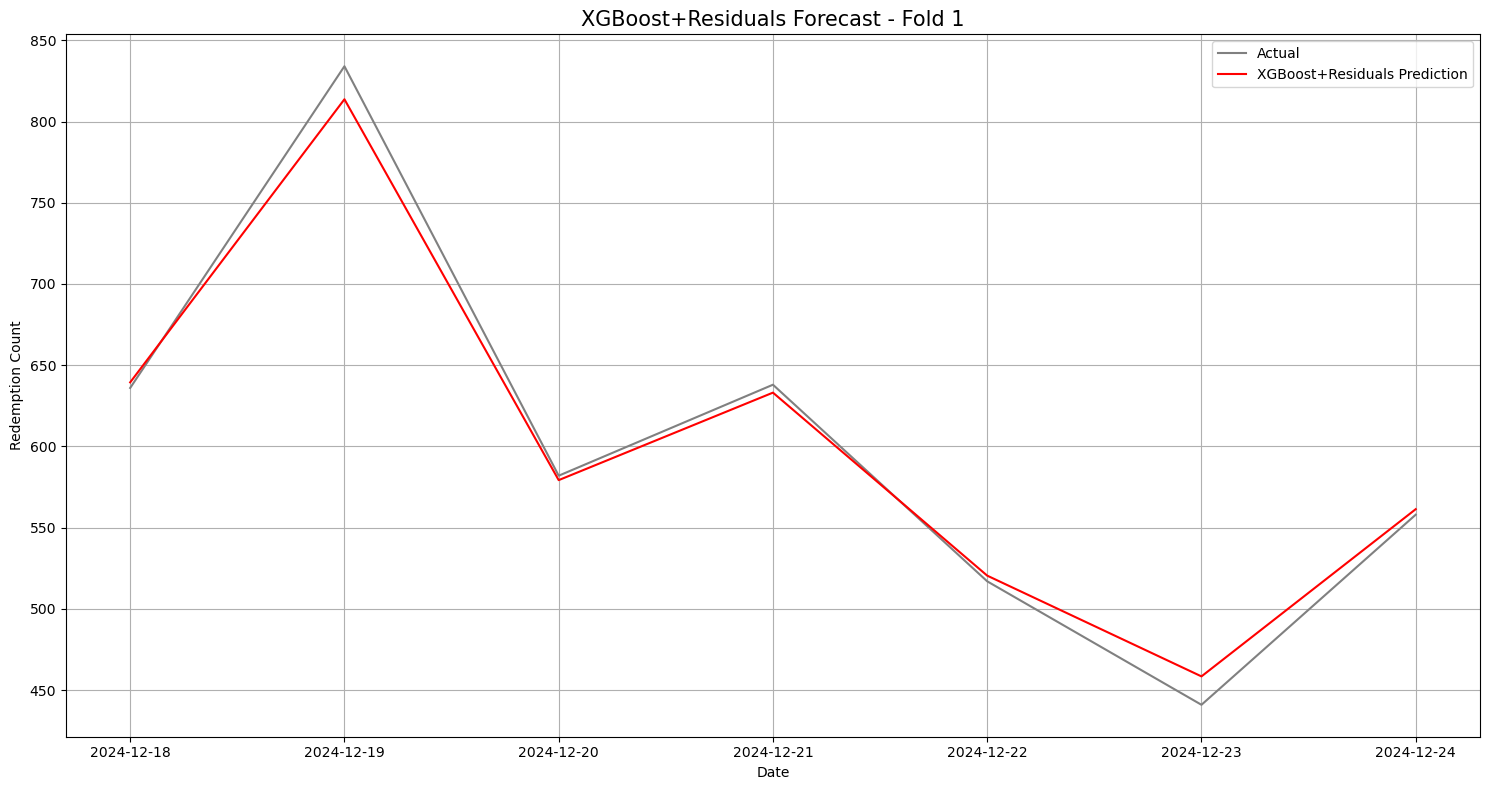

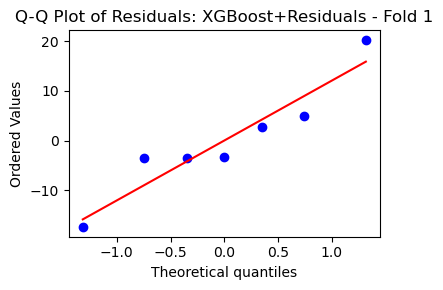

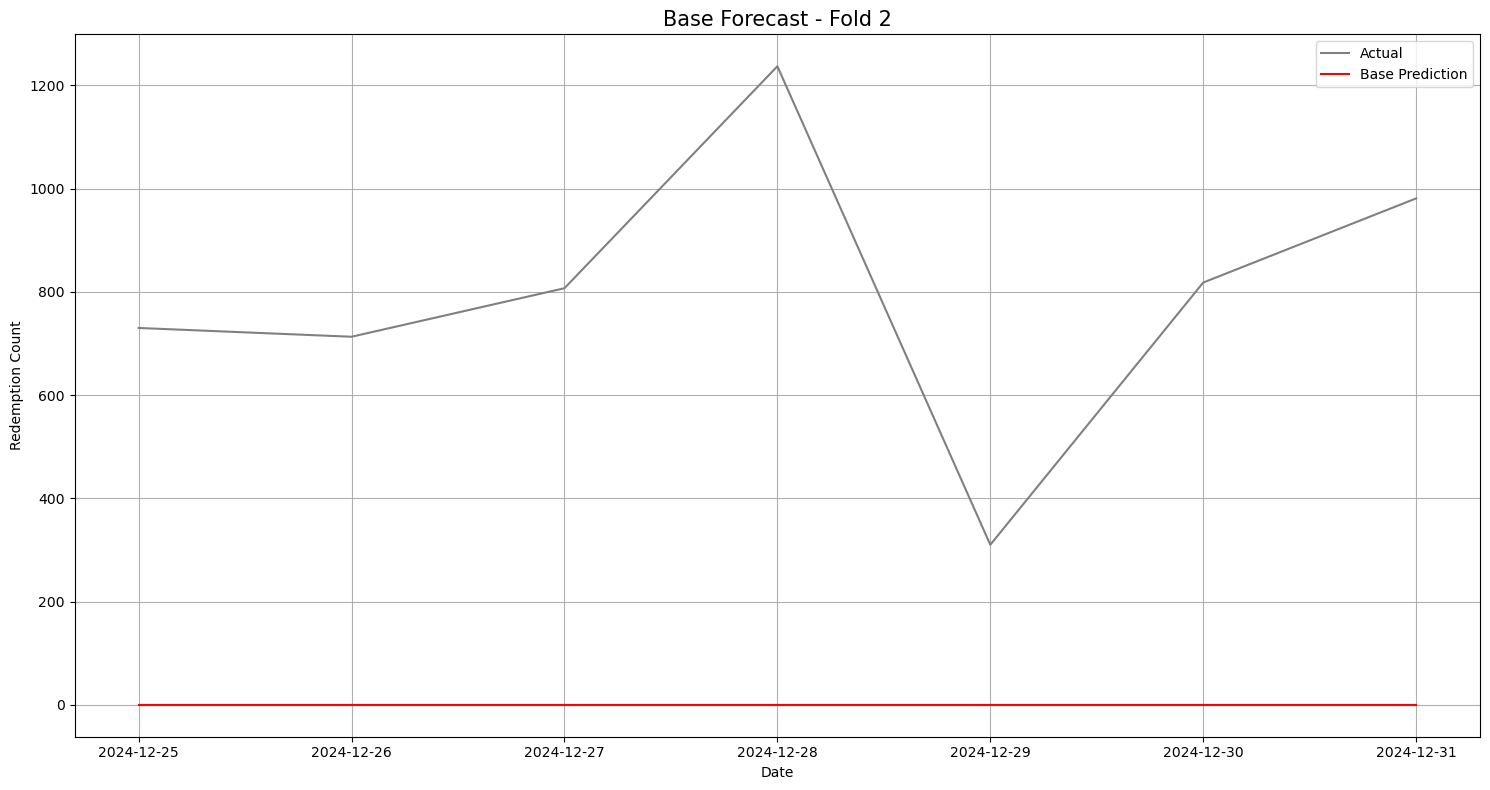

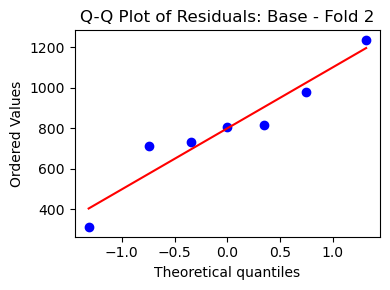

14:49:33 - cmdstanpy - INFO - Chain [1] start processing
14:49:33 - cmdstanpy - INFO - Chain [1] done processing


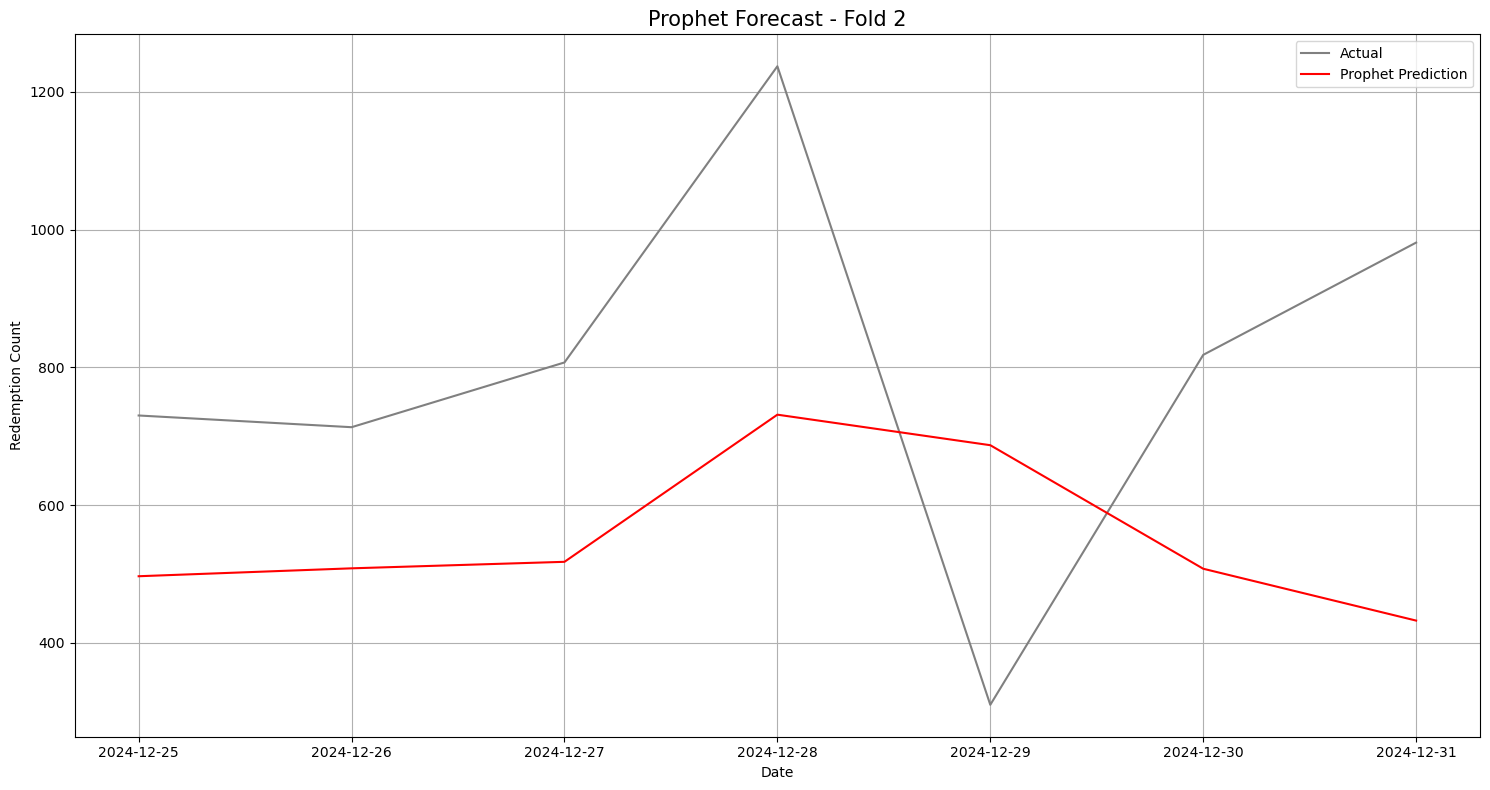

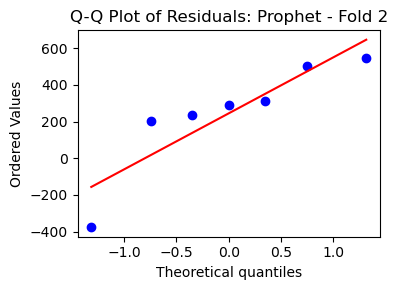

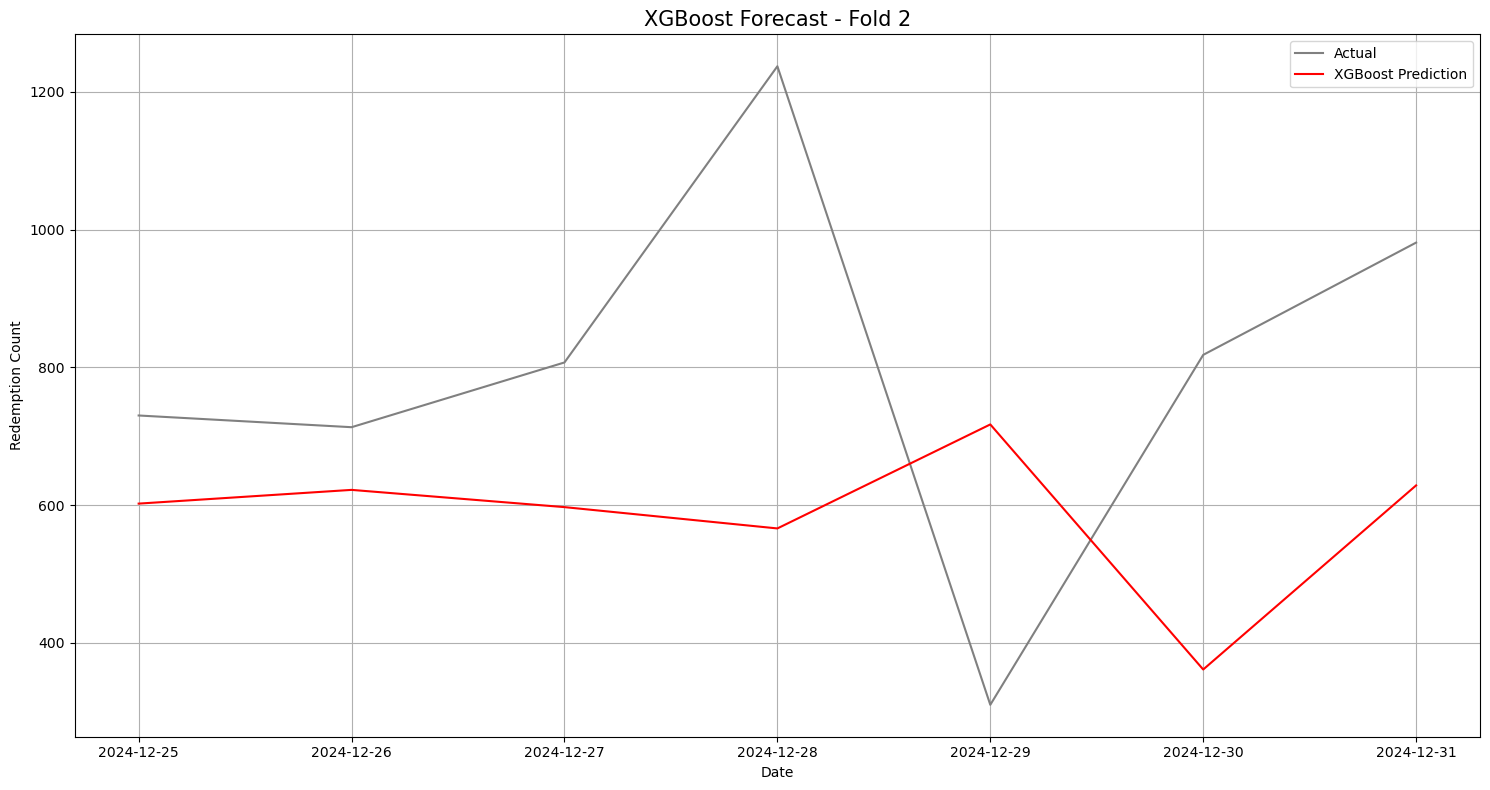

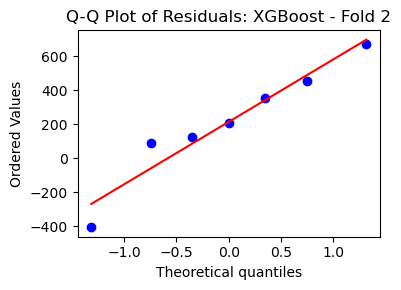

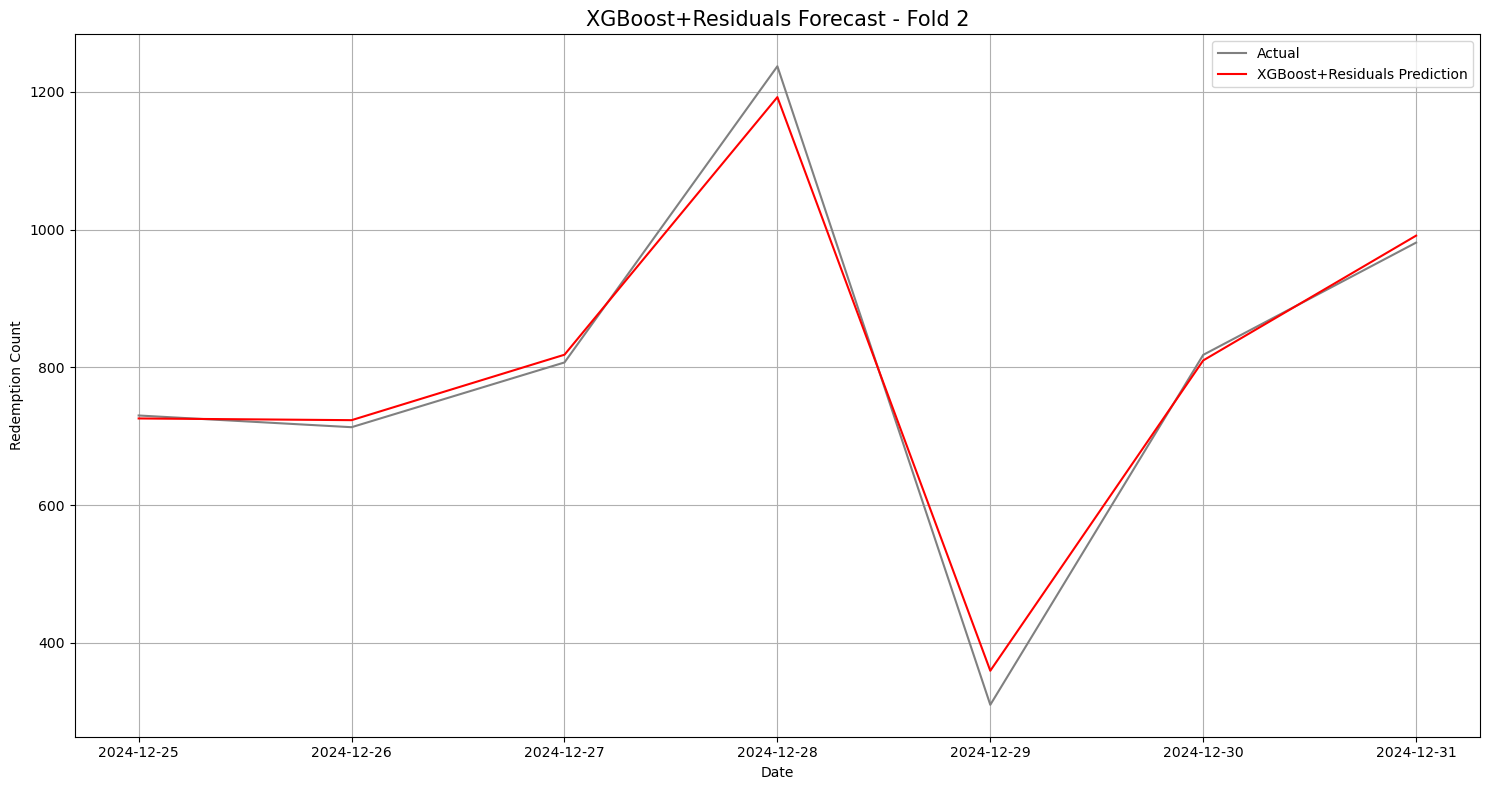

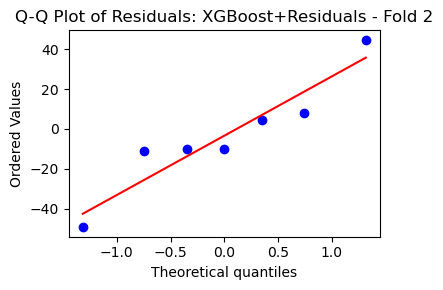

Available keys in rm.results: dict_keys(['Base', 'Prophet', 'XGBoost', 'XGBoost+Residuals'])


In [9]:
target_col = 'Redemption Count'
n_splits = 3
# Initialize the RedemptionModel with the daily data for 2022
test_size = 7  # Number of days for the test set
rm = RedemptionModel(df_daily_2022, target_col=target_col)
rm.run_models(n_splits=n_splits, test_size=test_size)

# Inspect the keys in the results to debug KeyError
print("Available keys in rm.results:", rm.results.keys())

In [10]:
end_time =time.time()
# Print the total run time
print(f"Total run time: {round(end_time - start_time,2)} seconds")

Total run time: 12.6 seconds


In [ ]:
# rm.results["Base"][2]['metrics']

{'MAE': 799.4285714285714,
 'MSE': 707181.7142857143,
 'RMSE': 840.9409695607144,
 'R2': -9.385119615618843}

In [ ]:
# rm.results["Prophet"][2]['metrics']

{'MAE': 352.79542528323014,
 'MSE': 139370.17141699223,
 'RMSE': 373.32314610400493,
 'R2': -1.0466817393273269}

In [ ]:
# rm.results["XGBoost"][2]['metrics']

{'MAE': 330.88480050223217,
 'MSE': 145356.60650264152,
 'RMSE': 381.2566150280432,
 'R2': -1.1345938603277967}

In [14]:
rm.results["XGBoost+Residuals"][2]['metrics']

{'MAE': 19.730412074497767,
 'MSE': 695.0429506840717,
 'RMSE': 26.363667246498004,
 'R2': 0.9897931408080349}

|Model | MAE | MSE | RMSE | 
|---   |---  |---  | ---  |
| Base |  799.42   |  707181.71    | 840.94     | 
| Prophet |  352.79   | 139370.17     | 373.32     |    
| XGBoost | 330.88  | 145356.61     | 381.26     |
| XGBoost+Residual Corrections | 19.73  |695.05      |26.36      |


#### Plot residuals: XGBoost

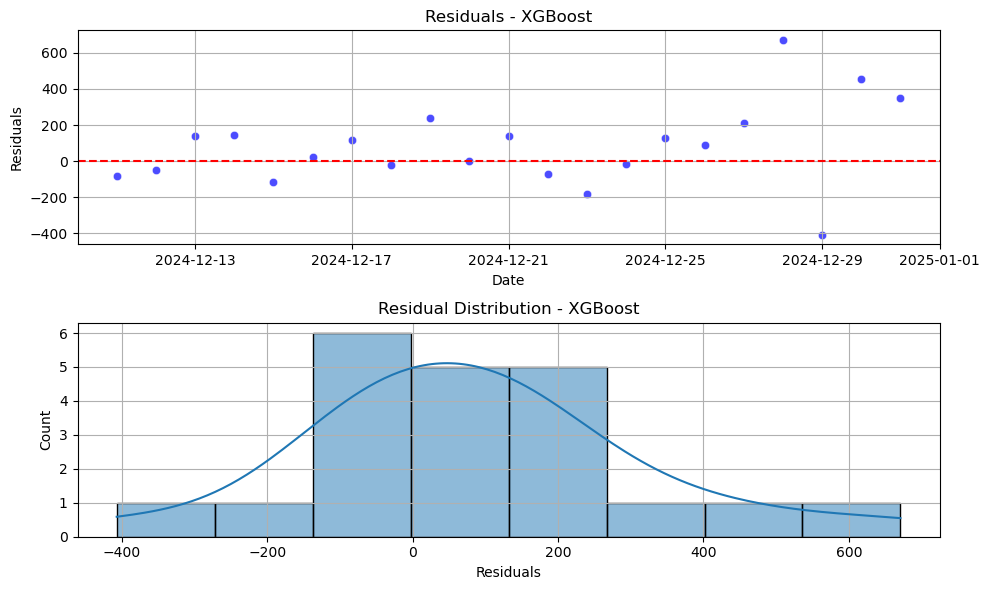

In [15]:
rm.plot_residual_distribution("XGBoost")

#### Plot residuals: XGBoost+Residual Correction

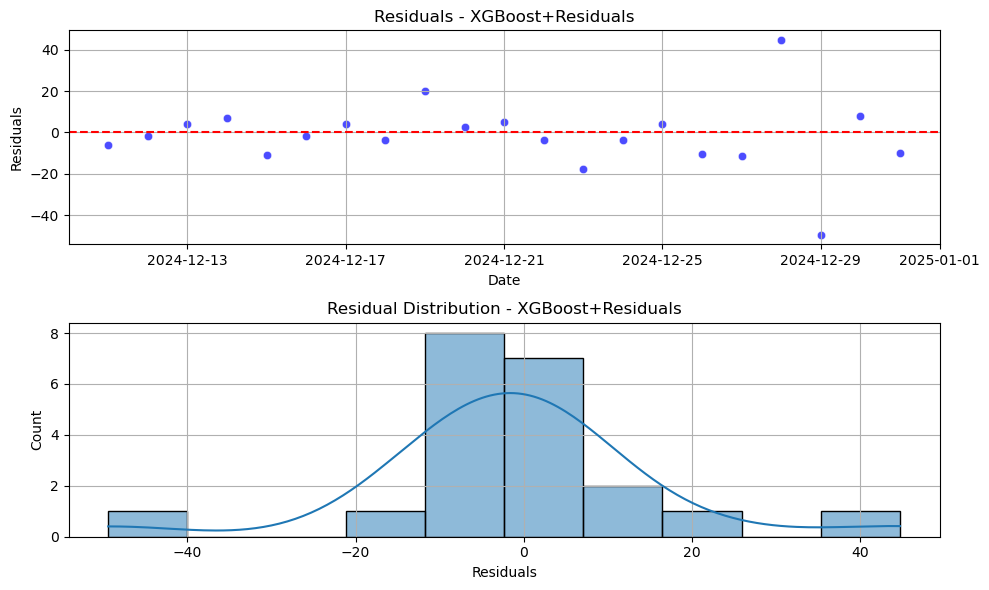

In [16]:
rm.plot_residual_distribution("XGBoost+Residuals")

#### Observations (Residual Distribution):
- **XGBoost (before residual correction)**: Residuals are highly dispersed, with large positive and negative errors (ranging from -400 to +600). The distribution is right-skewed with several outliers, indicating spike events not captured by the model. This suggests model underfitting during abnormal days (e.g., holidays, demand surges).

- **XGBoost + Residual Correction**: Residuals are now tightly clustered around zero, with most errors within ±20. The histogram shows a near-normal distribution, indicating improved model calibration and reduced bias. Spikes are better captured, and model variance has significantly decreased.

#### Model Explanibility & Feature Importance

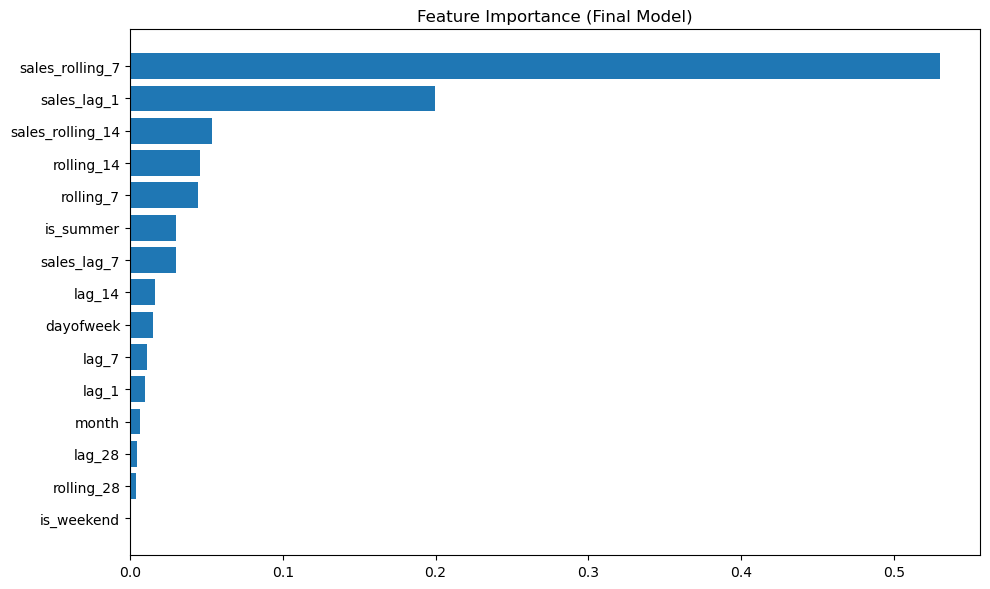

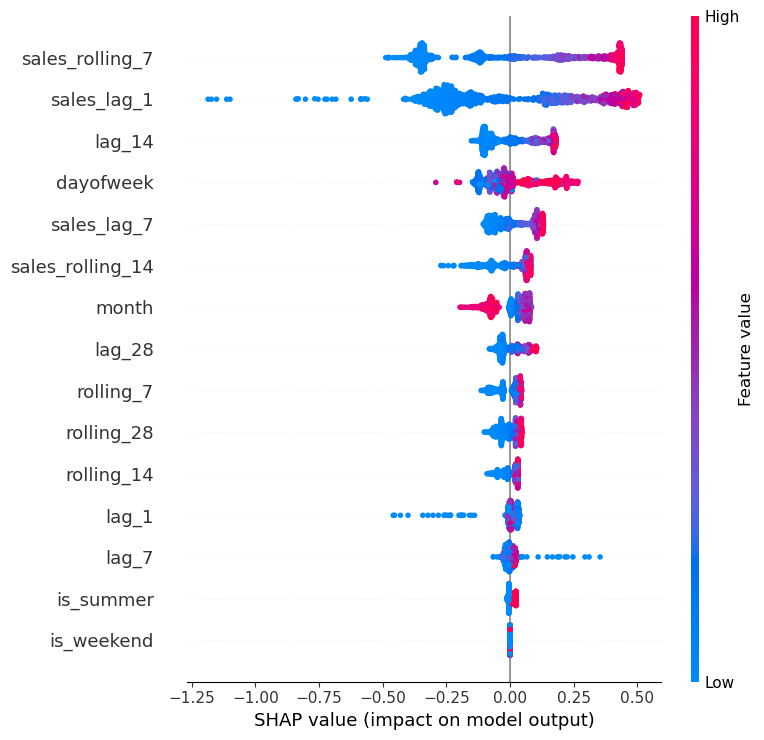

In [17]:
rm.train_final_model_and_show_explainability()
# rm.plot_feature_importance("XGBoost+Residuals")


#### Observations:
- The top predictors are sales_rolling_7 and sales_lag_1, indicating that recent sales patterns strongly influence redemption behavior. Calendar and lag features (e.g., is_weekend, month) contribute minimally.
The model heavily relies on short-term sales trends, confirming that recent purchase behavior is a key driver of ferry usage.
- The SHAP plot confirms that sales_rolling_7 and sales_lag_1 are the most impactful features on model predictions. High recent sales (pink) push predictions up; low values (blue) pull them down. Calendar effects like dayofweek and month have moderate but consistent impact. Many lag and rolling features have minimal individual influence, but add context. 